In [14]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Churn Prediction Workflow

## 1. Data Loading

In [15]:
# Load data
df = pd.read_csv('data/data_with_churn.csv')
# show column names
df.columns.tolist()

['contract_item_description',
 'contract_item_internal_id',
 'contract_item_product_category',
 'contract_item_product_description',
 'contract_item_support_end_date',
 'contract_item_support_start_date',
 'contract_item_concurrent_sessions',
 'description',
 'end_date_time',
 'start_date_time',
 'item_count',
 'customer_earliest_start',
 'customer_latest_end',
 'sla',
 'product_category',
 'service_level_regex',
 'otrs_version',
 'system_type',
 'feature_add_ons',
 'cancellation_date',
 'customer_country',
 'concat_volume',
 'concat_currency',
 'cancellation_date_orca',
 'end_customer_id',
 'churn']

## 2. Data Preprocessing

In [16]:
data = df.copy()

# Drop datetime and category columns
data = data.select_dtypes(exclude=['datetime64[ns]', 'category'])

# drop specific columns
data = data.drop(columns=['end_customer_id', 'contract_item_internal_id'])
# drop columns with time
data = data.drop(
    columns=['start_date_time', 'end_date_time', 'contract_item_support_start_date', 'contract_item_support_end_date',
             'customer_earliest_start', 'customer_latest_end', 'cancellation_date', 'cancellation_date_orca'])

print(data.columns)
# Identify categorical and numerical columns
categorical_cols = [x for x in data.columns if data[x].dtype == 'object']
numerical_cols = [x for x in data.columns if data[x].dtype in ['int64', 'float64']]

# Label Encoding for categorical variables
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col].astype(str))

# Prepare features and target
features = categorical_cols + numerical_cols
X = data[features]
y = data['churn']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# check for missing values
print(X.isnull().sum())

# replace missing values with 0
X = X.fillna(0)


Index(['contract_item_description', 'contract_item_product_category',
       'contract_item_product_description',
       'contract_item_concurrent_sessions', 'description', 'item_count', 'sla',
       'product_category', 'service_level_regex', 'otrs_version',
       'system_type', 'feature_add_ons', 'customer_country', 'concat_volume',
       'concat_currency', 'churn'],
      dtype='object')
contract_item_description             0
contract_item_product_category        0
contract_item_product_description     0
description                           0
sla                                   0
product_category                      0
service_level_regex                   0
otrs_version                          0
system_type                           0
feature_add_ons                       0
customer_country                      0
concat_currency                       0
contract_item_concurrent_sessions    11
item_count                            0
concat_volume                         1
chur

## 3. Feature Selection

In [17]:
def select_features(method='all', n_features=None):
        """
        Select best features using different methods
        
        Parameters:
        -----------
        method : str, optional (default='all')
            Feature selection method. Options:
            - 'correlation': Select based on correlation with churn
            - 'statistical': Use statistical F-test
            - 'rfe': Recursive Feature Elimination
            - 'importance': Use Random Forest feature importance
            - 'all': Return results from all methods
        
        n_features : int, optional
            Number of top features to select
        
        Returns:
        --------
        dict of selected features
        """
        results = {}
        
        # Correlation Analysis
        if method in ['correlation', 'all']:
            correlation = X.apply(lambda x: x.corr(y))
            results['correlation'] = correlation.abs().sort_values(ascending=False)
        
        # Statistical Feature Selection
        if method in ['statistical', 'all']:
            selector = SelectKBest(score_func=f_classif, k=n_features or len(X.columns))
            selector.fit(X, y)
            statistical_scores = pd.Series(
                selector.scores_, 
                index=X.columns
            ).sort_values(ascending=False)
            results['statistical'] = statistical_scores
        
        # Recursive Feature Elimination
        if method in ['rfe', 'all']:
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rfe = RFE(estimator=rf, n_features_to_select=n_features or 3)
            rfe.fit(X, y)
            rfe_ranking = pd.Series(
                rfe.ranking_, 
                index=X.columns
            )
            results['rfe'] = rfe_ranking
        
        # Feature Importance from Random Forest
        if method in ['importance', 'all']:
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(X, y)
            importance = pd.Series(
                rf.feature_importances_, 
                index=X.columns
            ).sort_values(ascending=False)
            results['importance'] = importance
        
        return results

## 4. Model Training and Evaluation

In [18]:
def train_model(test_size=0.5, random_state=42):
        """
        Train a Random Forest Classifier and evaluate its performance
        
        Parameters:
        -----------
        test_size : float, optional (default=0.2)
            Proportion of the dataset to include in the test split
        random_state : int, optional (default=42)
            Controls the shuffling applied to the data before splitting
        
        Returns:
        --------
        Trained model and performance metrics
        """        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Train Random Forest Classifier
        rf_classifier = RandomForestClassifier(
            n_estimators=5, 
            random_state=random_state
        )
        rf_classifier.fit(X_train, y_train)
        
        # Predictions
        y_pred = rf_classifier.predict(X_test)
        
        # Performance Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred)
        }
        
        # Detailed Classification Report
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix Visualization
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        
        return rf_classifier, metrics

## Example Usage

Feature Selection Results:

Correlation Feature Ranking:
churn                                1.000000
item_count                           0.396224
concat_currency                      0.283722
otrs_version                         0.207176
concat_volume                        0.138287
contract_item_description            0.099275
system_type                          0.083214
contract_item_product_description    0.078419
service_level_regex                  0.063773
description                          0.041275
customer_country                     0.032769
sla                                  0.026735
contract_item_concurrent_sessions    0.023878
feature_add_ons                      0.023058
product_category                     0.014583
contract_item_product_category       0.005515
dtype: float64

Statistical Feature Ranking:
churn                                1.159677e+17
item_count                           3.836338e+01
concat_currency                      1.803432e+01
otrs_version

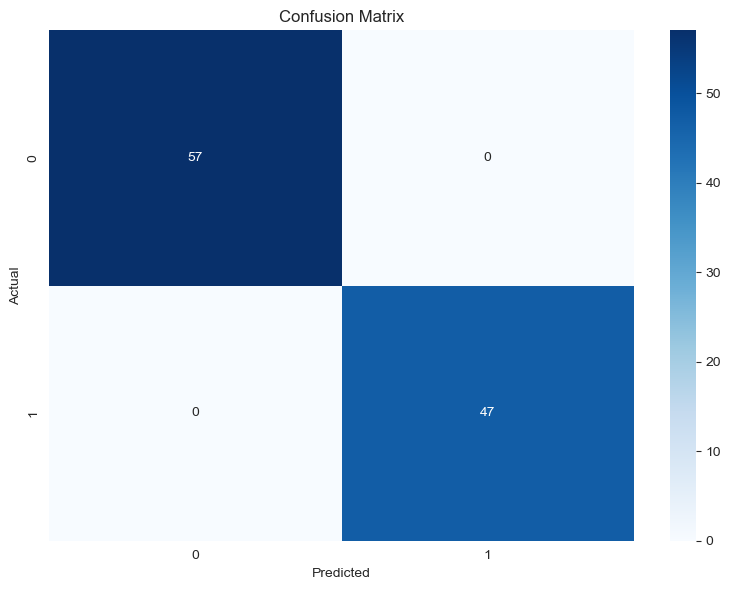


Model Performance Metrics:
accuracy: 1.0
precision: 1.0
recall: 1.0
f1_score: 1.0


In [19]:
# Select Features
print("Feature Selection Results:")
feature_selection = select_features(method='all')
for method, results in feature_selection.items():
    print(f"\n{method.capitalize()} Feature Ranking:")
    print(results)

# Train Model and Evaluate
print("\nModel Training and Evaluation:")
model, metrics = train_model()
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")